# Best fit coefficients to the best estimate ERFaci timeseries

Theme Song: Finger<br>
Artist: Elephant Gym<br>
Album: Balance<br>
Released: 2013

This is not used in AR6 anywhere but has been requested by Steve Smith

In [1]:
import json
import numpy as np
from fair.constants import molwt
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib.pyplot as pl
from tqdm.notebook import tqdm
from ar6.forcing.aerosol import aerocom_n, ghan

In [2]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


## Aerosol forcing

In [3]:
# Load up the best estimate
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
df['aerosol-cloud_interactions'].values

array([ 0.00000000e+00,  4.67354704e-03,  7.28138212e-03,  4.74173686e-03,
       -1.99972166e-03,  1.29312662e-03,  4.47120771e-03, -5.49177309e-03,
       -1.83020551e-03, -2.64390880e-03, -6.78170966e-03, -5.14519250e-03,
       -1.57333823e-03, -1.83110994e-03,  8.00268385e-03, -4.60343889e-03,
        7.07444803e-04,  1.08770729e-04, -1.23731150e-02, -6.22879490e-03,
       -6.49658870e-03,  1.82386766e-03,  5.47185651e-03,  3.94208842e-03,
       -8.23838474e-03, -3.45031855e-03,  8.30593936e-04, -5.31788423e-03,
       -9.60609043e-03, -4.26116182e-03, -1.10866565e-02, -7.96341140e-03,
       -5.71696761e-03, -3.91186202e-03,  2.46166821e-03, -6.22973693e-03,
       -1.94571899e-03, -6.49628146e-03, -1.81289442e-02, -1.16800317e-02,
       -1.27449764e-02, -4.90459409e-03, -1.95014748e-03, -2.26454438e-03,
       -1.47577997e-02, -9.94367821e-03, -4.82052039e-03, -1.12701417e-02,
       -1.49239872e-02, -1.28899834e-02, -1.65360257e-02, -1.37828061e-02,
       -1.39641998e-02, -

In [4]:
p, cov = curve_fit(
    ghan, 
        [
            emissions_ceds_update.loc['1750':'2019', 'SO2'].values.T-emissions_ceds_update.loc['1750':'1750', 'SO2'].values.T,
            (
                emissions_ceds_update.loc['1750':'2019', 'BC'].values.T-emissions_ceds_update.loc['1750':'1750', 'BC'].values.T+
                emissions_ceds_update.loc['1750':'2019', 'OC'].values.T-emissions_ceds_update.loc['1750':'1750', 'OC'].values.T
            ),
        ],
        df['aerosol-cloud_interactions'].values,
        bounds = ((0, 0, 0), (np.inf, np.inf, np.inf))
)

In [5]:
p

array([  2.09841432, 260.34644166, 111.05064063])

In [6]:
mean_emulation = ghan([
    emissions_ceds_update.loc['1750':'2019', 'SO2'].values.T-emissions_ceds_update.loc['1750':'1750', 'SO2'].values.T, 
    emissions_ceds_update.loc['1750':'2019', ['BC','OC']].sum(axis=1).values.T-emissions_ceds_update.loc['1750':'1750', ['BC','OC']].sum(axis=1).values.T,
], p[0], p[1], p[2])

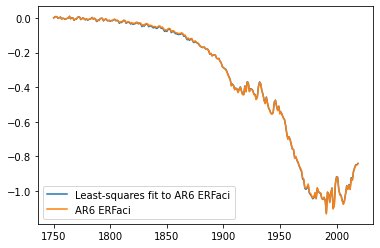

In [7]:
pl.plot(np.arange(1750, 2020), mean_emulation, label='Least-squares fit to AR6 ERFaci')
pl.plot(np.arange(1750, 2020), df['aerosol-cloud_interactions'].values, label='AR6 ERFaci')
pl.legend()